# Bayesian linear regression with Pyro

## Linear regression

We can start by importing some helpful libraries, including Pyro:

In [17]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

We want to see if there is a relationship between ruggedness of terrain in a country and its GDP. According to a study, ruggedness is related to poor economic performance outside of Africa, but that the relationship is reversed in Africa.

We import the data

In [18]:
# Import data
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
# Log-transform GDP, as it is heavily skewed and would lead to numerical 
# problems otherwise
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

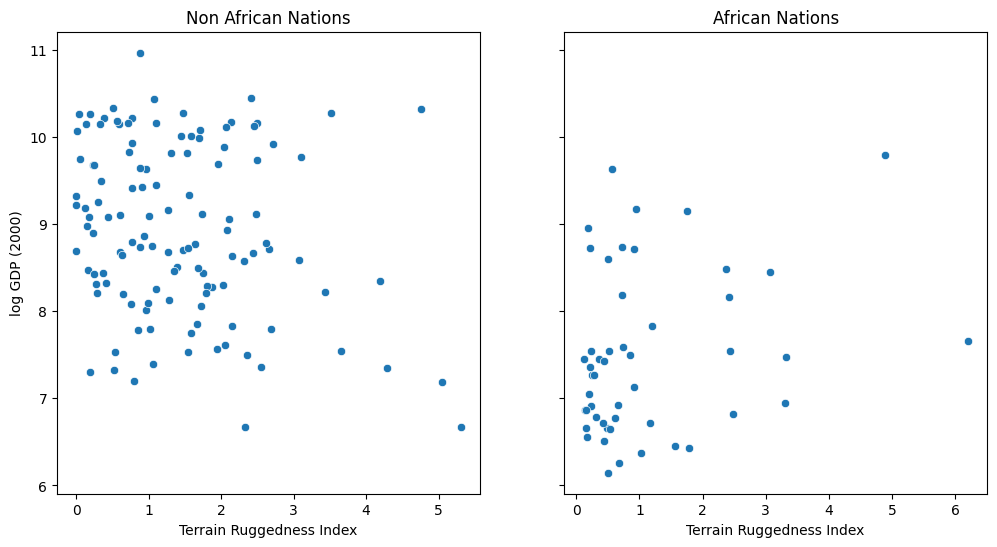

In [19]:
# Specify plot specifics and plot hte data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

Let us consider the classical linear model $Y = wX+b+\epsilon$, where $w$ and $b$ are set parameters, while $\epsilon$ is a stochstic variable, giving random noise. We can train such a model with the following code in Pyro:

In [20]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model, import linear model from pyro.nn
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
        print(name, param.data.numpy())

[iteration 0050] loss: 3626.3965
[iteration 0100] loss: 1905.7032
[iteration 0150] loss: 1312.6702
[iteration 0200] loss: 983.1520
[iteration 0250] loss: 748.9347
[iteration 0300] loss: 569.8841
[iteration 0350] loss: 434.6021
[iteration 0400] loss: 336.1720
[iteration 0450] loss: 267.4264
[iteration 0500] loss: 221.2810
[iteration 0550] loss: 191.4707
[iteration 0600] loss: 172.9194
[iteration 0650] loss: 161.7909
[iteration 0700] loss: 155.3535
[iteration 0750] loss: 151.7619
[iteration 0800] loss: 149.8291
[iteration 0850] loss: 148.8257
[iteration 0900] loss: 148.3236
[iteration 0950] loss: 148.0812
[iteration 1000] loss: 147.9685
[iteration 1050] loss: 147.9181
[iteration 1100] loss: 147.8963
[iteration 1150] loss: 147.8873
[iteration 1200] loss: 147.8837
[iteration 1250] loss: 147.8823
[iteration 1300] loss: 147.8818
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8816
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94775

We can also plot the resulting linear models along with the data:

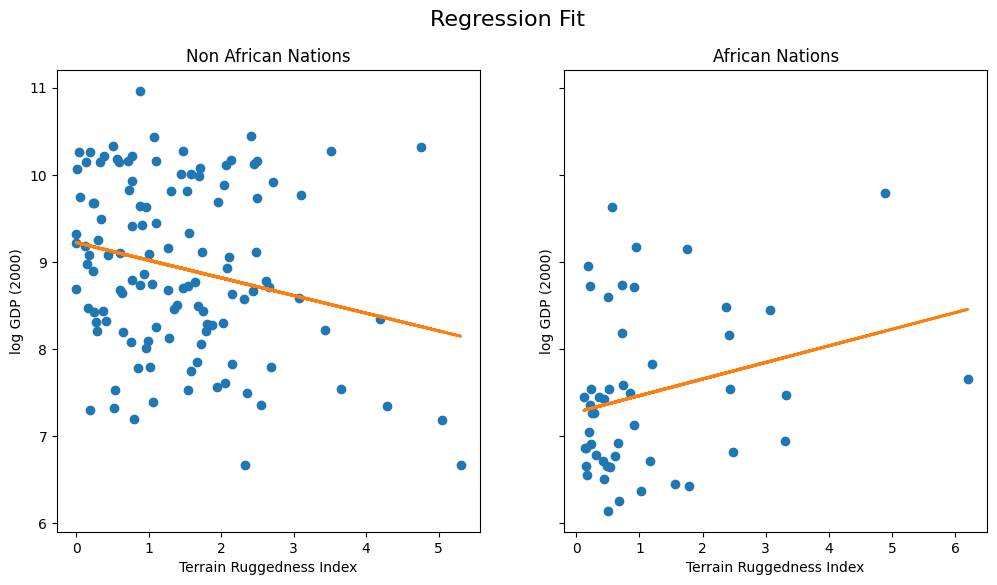

In [21]:
# Specify specifis for plot and plot data with linear model
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Bayesian linear regression

In order to make our model Bayesian, we put prior distributions on the parameters $w$ and $b$.

In [22]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # Use PyroSample to specify that parameter is stochastic
        # and specify its prior distribution
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

The biggest difference from a normal linear model in PyTorch is that we use ```PyroSample``` instead of  ```param```, to specify that the parameter is stochastic and has a prior distribution.

We need an inference method to learn the posterior distribution for the unobserved parameters. In this case we can use Stochastic Variational Inference (SVI). To do this we set up a guide, which determines a family of distributions and then SVI tries to find the approximate posterior which is closest to the true one (by minimising the KL divergence).

In [23]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, with the difference that in this case, we’ll use the Evidence Lower Bound (ELBO) objective instead of the MSE loss by constructing a ```Trace_ELBO``` object that we pass to ```SVI```.

In [24]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

We use ```Adam``` from Pyros ```optim``` and not from ```torch```. Optimizers in ```pyro.optim``` are used to optimize and update parameter values in Pyro’s parameter store. In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the ```SVI``` class automatically. We can take steps along the ELBO gradient by calling the step method of SVI.

In [25]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.2990
[iteration 0101] loss: 2.2842
[iteration 0201] loss: 1.6477
[iteration 0301] loss: 1.4587
[iteration 0401] loss: 1.4484
[iteration 0501] loss: 1.4612
[iteration 0601] loss: 1.4655
[iteration 0701] loss: 1.4519
[iteration 0801] loss: 1.4684
[iteration 0901] loss: 1.4650
[iteration 1001] loss: 1.4640
[iteration 1101] loss: 1.4835
[iteration 1201] loss: 1.4635
[iteration 1301] loss: 1.4560
[iteration 1401] loss: 1.4680


We can examine the obtained parameters by fetching param store

In [26]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2696, -1.7865, -0.1680,  0.3964,  9.1909])
AutoDiagonalNormal.scale tensor([0.0675, 0.1331, 0.0392, 0.0807, 0.0648])


We get uncertainty estimates (```AutoDiagonalNormal.scale```) instead of point estimates.

By using ```AutoDiagonalNormal.quantiles``` we can look at the distributions more clearly. This method unpacks the latent variables from the autoguide and giv the quantiles, while constraining them to the variables support.

In [27]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.8987, 0.9367, 0.9761]),
 'linear.weight': tensor([[[-1.8762, -0.1944,  0.3420]],
 
         [[-1.7865, -0.1680,  0.3964]],
 
         [[-1.6968, -0.1415,  0.4508]]]),
 'linear.bias': tensor([[9.1472],
         [9.1909],
         [9.2346]])}